# Laboratoire 1 : Extraction de primitives
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | LEMARCHANT HUGO - AP85480 • TAN ELODIE - TANE25619607 •  JACQUES-SYLVAIN LECOINTRE LECJ19128301| 
|-----------------------|--------------------------------------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine                              |
| Session               | AUTOMNE 2018                                                                         |
| Groupe                | C                                                                                    |
| Numéro du laboratoire | 1                                                                                    |
| Professeur            | Prof. Hervé Lombaert                                                                 |
| Chargé de laboratoire | Pierre-Luc Delisle                                                                   |
| Date                  | 2018/09/27                                                                           |

In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import cv2
import core
import matplotlib.pyplot as plt
import sys
import os, random
import math
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
import scipy.ndimage as nd
import csv
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
# Hugo
pathHugo = "E:\\DocsPerso\\DocsBoulot\\ETS-MTL\\GTI770-02-SystIntel&MachineLearning\\data\\data\\images\\"
# JS
pathJS= '/Users/jslecointre/Documents/DataScience/courses/MACHINE_LEARNING/TP/data/images/'
pathElodie = '/Users/raen/Documents/UTC/ETS/GTI770/GTI770-Data/images/'
exts = ".jpg"
nb_img = "107975"

In [4]:
# choose your correct path here
path=pathElodie
path=pathJS

In [5]:
imgFile = cv2.imread(path + nb_img + exts)
GP=core.GalaxyProcessor(path)

### Toutes les fonctions suivantes se trouvent dans galaxy_processor.py, elle sont appelées par la fonction get_features de la classe GalaxyProcessor. Ci-dessous le détail des fonctions : 

### Feature #1 ratio_aspect

In [6]:
def get_ratio_aspect(self, image):
        """
        Calculate the ratio of the bounding revtangle containing the largest contoured element. Most of the time the galaxy.
        Args : image read by the cv2.imread function.
        Returns the ratio and the values of width and lenght
        """
        crop = 150
        epsilon = 0.0000000001
        img = image.copy()
        if not isinstance(img, np.ndarray):
            return -1, (None, None)
        img = img[212-crop:212+crop, 212-crop:212+crop]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        im2,contours,hierarchy = cv2.findContours(thresh, 2, 2)
        cnt = max(contours, key = lambda cnt : len(cnt))
        rect = cv2.minAreaRect(cnt)
        ratio = rect[1][0]/(rect[1][1]+epsilon)
        #print("ratio = {}".format(ratio))
        return ratio, (rect[1][0], rect[1][1])

### Feature #2 CCV

In [7]:
def get_ccv(self, image, threshold, nb_colors):

        """
        This feature mark each pixel as belonging to a coherent or incoherent regions.
        A region R of connected pixels satisfy this rule : For each p1, p2 ∈ R,
        there exist a path of adjacent pixels from p1, p2
        (connectedComponentsWithStats is used to retrieve these areas)

        Each pixel is checked for its members to a coherent area/region.
        Coherent pixels are the pixels belonging an areas of size >= threshold
        InCoherent pixels are the pixels an areas of size < threshold

        Args:
            image     : an OpenCV standard color image format.
            threshold : minimum area size for coherent regions
            nb_colors : size of the Color space to discretize the image

        Returns:

            The CCV vector of length 2 * nb_colors.

              C1          |        C2    |...|         CN    |       I1          |      I2    |... | IN
        nb coherent pix   |              |   |               |nb incoherent pix  |            |    |
        for color1        | for color2   |   | for colorN    |for color1         |for color2  |    |for colorN

        """

        def quantize_color(img, nb_colors=64):
            div = 256//nb_colors
            rgb = cv2.split(img)
            quantized_list = []
            # quantize nb_colors colors for each channel
            for ch in rgb:
                vf = np.vectorize(lambda x, div: int(x//div)*div)
                quantized = vf(ch, div)
                quantized_list.append(quantized.astype(np.uint8))
            # Merge the channels after quantization
            d_img = cv2.merge(quantized_list)
            return d_img

        img = image.copy()
        im_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=self.crop_image(im_color, 212-80, 212+80)

        # blur to eliminate slight variations between the adjacent pixels
        img = cv2.GaussianBlur(img, (3, 3), 0)
        # quantize image into nb_colors
        img = quantize_color(img, nb_colors)
        bgr = cv2.split(img)
        coherent_pixels = np.zeros(nb_colors)
        incoherent_pixels = np.zeros(nb_colors)
        # labeling
        for (i, ch) in enumerate(bgr):
            (ret, th) = cv2.threshold(ch, 127, 255, 0)
            (ret, labeled, stat, centroids) = cv2.connectedComponentsWithStats(th, None,cv2.CC_STAT_AREA, None, connectivity=8)
            # generate areas
            areas = [[v[4], label_idx] for (label_idx, v) in enumerate(stat)]
            coords = [[v[0], v[1]] for (label_idx, v) in enumerate(stat)]
            # Counting coherent and incoherent pixels over each area
            for (area, coord) in zip(areas, coords):
                area_size = area[0]
                (x, y) = (coord[0], coord[1])
                if x < ch.shape[1] and y < ch.shape[0]:
                    bin_idx = int(ch[y, x] // (256 // nb_colors))
                    if area_size >= threshold:
                        # COHERENT PIXELS (belong to area >= Threshold pixels )
                        coherent_pixels[bin_idx]+= area_size
                    else:
                        # INCOHERENT PIXELS (belong to area < Threshold pixels )
                        incoherent_pixels[bin_idx]+= area_size
        return [coherent_pixels, incoherent_pixels]

### Feature #3 Circularity

In [8]:
def calculate_circularity(self, image):
        """calculateCircularity
        Fonction calculant la circularité d'une image de galaxie grâce à la fonction C = 4pi * A/P2.
        Args:
            img (int): L'image pour laquelle nous voulons calculer la circularité.
        Returns:
            circularity: La valeur de retour. Elle est définie entre 0 et 1.
                        Plus la valeur est proche de 1, plus la galaxie est circulaire.

        """
        img = image.copy()
        img = self.crop_image(img, 212-85, 212+85)
        log = nd.gaussian_laplace(img, sigma=20)
        img = img - log
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY);
        ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        kernel = np.ones((3,3),np.uint8)
        dilation = cv2.dilate(thresh,kernel,iterations = 1)
        # Get moment to calculate area
        img2, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour = max(contours, key = lambda cnt : len(cnt))
        area = cv2.moments(contour)['m00']
        #Get perimeter :
        perimeter = cv2.arcLength(contour,True)
        # Circularity
        circularity = 4 * math.pi * area / (perimeter**2)
        return circularity

In [9]:
GP.calculate_circularity(imgFile)

0.7887232650707026

## Fonction calcul des primitives

In [10]:
def calculateAttributes(n):
    """Function to calculate the attributes of the galaxy images.

    Args:
        n: number of images for which we want to calculate the attributes.

    Returns:
        Two lists : 
            - The feature vectors for each image : ratio, circularity and CCV.
            - The associated label to each feature vector.

    """
    df = pd.read_csv('galaxy/galaxy_label_data_set.csv', delimiter = ',')
    df = df.groupby('class').apply(lambda x: x.sample(n//2)).reset_index(drop=True)
    return [GP.get_features(x) for x in df.id.values], df['class'].values

In [11]:
N=5000
attributes=calculateAttributes(N)
features=np.array(attributes[0])

In [12]:
labels=np.array(attributes[1])
label_colors= [ 'red' if y=='smooth' else 'blue' for  y in labels]
label_values= [ 1 if y=='smooth' else 2 for  y in labels]

# extract each feature separa
circularity = features[:,1:2].T[0]
aspect_ratio= features[:,0:1].T[0]
ccv = features[:,2:]


## Analyse des primitives
### Circularité

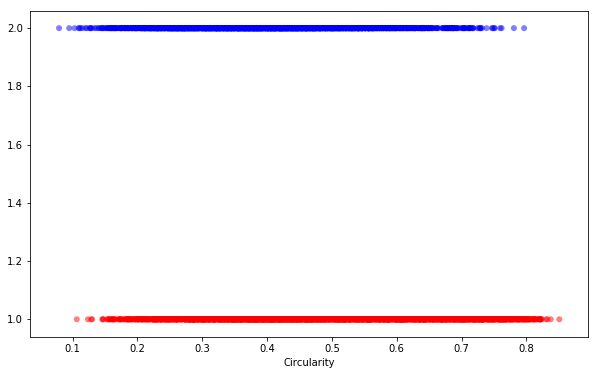

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(circularity, label_values,c=label_colors,marker='o',alpha=0.5, edgecolors='none')
plt.xlabel('Circularity')
plt.show()

### RatioAspect

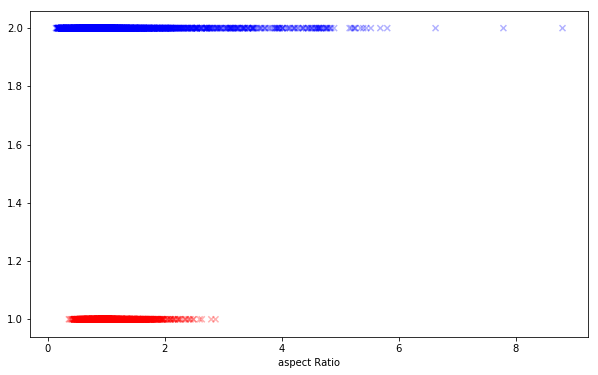

In [14]:
plt.figure(figsize=(10,6))
plt.scatter(aspect_ratio,label_values,c=label_colors,marker='x',alpha=0.3, edgecolors='none')
plt.xlabel('aspect Ratio')
plt.show()

### Ratio-aspect vs Circularity

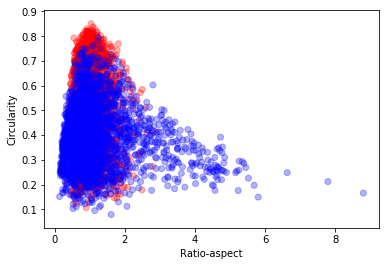

In [15]:
plt.scatter(aspect_ratio,circularity,c=label_colors,alpha=0.3)
plt.xlabel('Ratio-aspect')
plt.ylabel('Circularity')
plt.show()

### CCV - TSNE

example of CCV feature vector computation

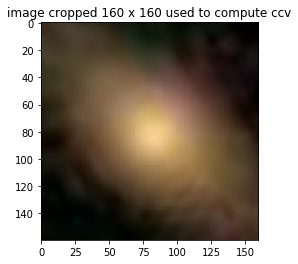

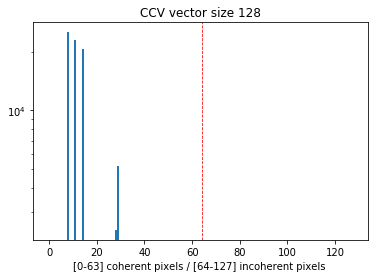

In [16]:
GP=core.GalaxyProcessor(path)
filename=random.choice(os.listdir(path))
coherence_threshold = 160**2*0.01
nb_colors = 64
img = cv2.imread('{0}{1}'.format(path,filename))

X = [x for x in range(nb_colors * 2)]
Y = GP.get_ccv(img, coherence_threshold, nb_colors)

cropped=GP.crop_image(img, 212-80, 212+80)
im = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.title('image cropped 160 x 160 used to compute ccv')
plt.show()

plt.bar(X, list(Y[0])+list(Y[1]), align='center')
plt.title('CCV vector size {0}'.format(nb_colors*2))
plt.axvline(x=nb_colors,color='r',linestyle='dashed',linewidth=0.8)
plt.yscale('log')
plt.xlabel("[0-63] coherent pixels / [64-127] incoherent pixels ")
plt.show()

la caracteristique CCV etant un vecteur de taille 128 , il est impossible de visualiser en 2D la repartition des valeurs selon les classes
le TSNE est utilise pour cela et visualiser des donnees avec une haute demensionnalite.Cet algorithme non lineaire permet de de visualiser en 2D la caracteristque ccv en 2D.

In [17]:
import numpy as np
from sklearn.manifold import TSNE
ccv = features[:,2:]
X_embedded = TSNE(n_components=2).fit_transform(ccv)

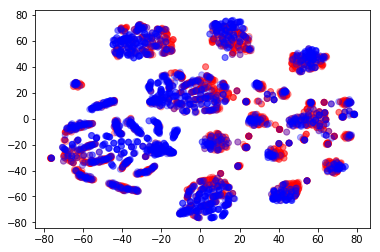

In [18]:
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=label_colors,alpha=0.3,)
plt.show()

## Arbre de décision

In [19]:
X = attributes[0]
Y = attributes[1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

clf = tree.DecisionTreeClassifier(max_depth = 10)
clf = clf.fit(X_train, Y_train)

In [26]:
clf.score(X_test, Y_test)

0.7333333333333333

In [39]:
with open("arbre_galaxy.dot", "w") as f:
    f = tree.export_graphviz(clf, out_file=f) 

### Cross-validation

In [21]:
scores = cross_val_score(clf, X, Y, cv=10)

cross_validation = sum(scores)/10
print(cross_validation)

X_predict=clf.predict(X_test)
CM = confusion_matrix(X_predict, Y_test)
print(classification_report(X_predict,Y_test))
print(CM)

0.7322
             precision    recall  f1-score   support

     smooth       0.79      0.71      0.75       832
     spiral       0.68      0.76      0.72       668

avg / total       0.74      0.73      0.73      1500

[[591 241]
 [159 509]]


## Questions

### Question 1 : Introduction et revue de la littérature

Après lecture des différents papiers de recherche, nous nous sommes concentré sur Morphological classification of galaxies into spirals and non-spirals (D. Dhami). En effet, ses travaux répondent parfaitement à la problématique qui nous est posée, c'est à dire la différenciation entre les galaxies rondes et celles en forme de spirale. Plusieurs caractéristiques de galaxies sont étudiées dans sa recherche, et elle explicite aussi celles qui fonctionnent le mieux. 


### Question 2

Nous avons donc choisi d'étudier :

- La circularité
- CCV
- Ratio-aspect

Pour ce qui est de la circularité, nous avons effectué plusieurs recherches sur comment la calculer. La plupart des sites mentionnent la formule $ C = 4 * \pi * area / P^2 $.

Le choix de ces features s'est fait à partir de la documentation fournie et des papiers de recherche. Nous avons choisi une caractéristique "humainement parlante" qu'est la circularité, une autre simplement implémentable qu'est le ratio de l'aspect qui semble relativement discriminante. Enfin dans un des papiers de recherche, la CCV semblait être la caractéristique la plus discriminante.Cette derniere de tient pas compte de la forme de l'image mais aggrege l'ensemble des pixels appartenant a des zones de coherence par couleur.

### Question 3

Circularité : cette feature semble être suffisamment discriminante dans la mesure où l'on observe des variations nettes de forme dans les bras d'une spirale ce qui amène la moyenne de circularité des spécimens appartenants à cette classe les 0.4 (sachant qu'un objet totalement circulaire aura une valeur de 1). Cependant, pour les galaxies smooths, il est très difficile de leur faire atteindre ce score parfait de circularité compte tenu de l'éclairage et du bruit de l'image. C'est pourquoi l'on obtient souvent des résultats assez similaires. La vue de la galaxie va aussi jouer car c'est la forme qui est étudiée ici.

Ratio-aspect : Au vue des graphiques, on peut remarquer qu'une partie des spirales est identifiée par un ratio largement différent de 1. Cependant, il se trouve qu'une certaine partie des galaxies spirales nous sont présentées de face, hors dans ce cas là ce critère est assez peu utile car elle nous apparait assez circulaire. Dans ce cas-ci, le rectangle qui contient la galaxie est en fait un carré ; par conséquent le ratio vaut 1. 

### Question 4
Plus $max-depth$ est petit, plus la valeur du score est petite. En effet, il y aura moins de primitives qui vont permettre de choisir la bonne classification. Cependant, lorsque $max-depth$ est trop grand, on aura fait un over-fitting. En effet, la profondeur de l'arbre étant très grande, l'algorithme apprendra beaucoup mieux des données d'apprentissage. Cependant, sur les données de test, l'algorithme donnera de moins bonnes valeurs.

### Question 5

Nous aurions pu prendre en compte la couleur du noyau de la galaxie qui est un indicateur de l'âge de la galaxie. Hors l'âge influence la forme de la galaxie. En effet, les galaxies les plus âges ont perdu de la vitesse de rotation ce qui donne la forme caractéristique des galaxies dites "smooth". [5]

### Conclusion

Nous avons pu vous présenter notre étude d'extraction de features sur le dataset Galaxy. Nous nous sommes essentiellement basé sur la revue de littérature pour choisir un triplet de features qui doivent se compléter par leurs propriétés : le CCV qui fait une analyse sans contexte de l'image, tandis que nos deux autres caractéristiques dépendent énormément du contexte de recherche de galaxie et sont très attachées à la forme de celle-ci. Nous n'avons pas implémenté d'autres features mais nous pensons que la combinaison des 3 répond suffisamment au problème à condition de l'entrainer sur assez d'images pour tirer partie de CCV et de son vecteur de 128 caractéristiques.

Nous obtenons une précision et un rappel d'envion 0.75 pour chaque classe sur 5000 images en ten-fold cross-validation. C'est raisonnable même nous aurions pu faire mieux : un meilleur pré-traitement des images en amont des extractions des caractéristiques aurait probablement amélioré le score. Le fine-tune des hyperparamètres aurait aussi permis d'avoir des features plus discriminantes (hyperparamètres : seuil du nombre de pixels de cohérence pour CCV, threshold et crop pour ratio-aspect, threshold pour circularité).

### Bibliographie
[1] http://scikit-learn.org/stable/modules/cross_validation.html  
[2] http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html  
[3] Dhami, Devendra. (2015). Morphological classification of galaxies into spirals and non-spirals.   10.13140/RG.2.2.22792.62727.   
[4] https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html  
[5] https://fr.wikipedia.org/wiki/Galaxie_spirale 